In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from torch.nn import *
import pandas as pd
import numpy as np
import cv2
from FocalLoss import *
from ResNet_multichannel import get_arch as ResNet
from Stratify_Oversample_Dataset import create_dataset

In [3]:
path = Path('/home/ubuntu/Kharbanda/Protein Atlas/Data')
test_path = path/'test'
train_path = path/'train'

In [4]:
df = pd.read_csv(path/'train.csv')
df.head()

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18


In [5]:
# df = create_dataset(df)
df = pd.read_csv(path/'Ready_Dataset.csv', index_col=0)
df.head()

,Id,Target,is_valid
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0,True
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0,True
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5,True
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1,False
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18,False


In [6]:
classes = """
Nucleoplasm  
Nuclear membrane   
Nucleoli   
Nucleoli fibrillar center   
Nuclear speckles   
Nuclear bodies   
Endoplasmic reticulum   
Golgi apparatus   
Peroxisomes   
Endosomes   
Lysosomes   
Intermediate filaments   
Actin filaments   
Focal adhesion sites   
Microtubules   
Microtubule ends   
Cytokinetic bridge   
Mitotic spindle   
Microtubule organizing center   
Centrosome   
Lipid droplets   
Plasma membrane   
Cell junctions   
Mitochondria   
Aggresome   
Cytosol   
Cytoplasmic bodies   
Rods & rings
"""

classes = classes.split('\n')[1:-1]

In [7]:
def save_model(model, Freezed='F', Size='smol', Iter = 1):
    model.save(f'Proteins_{Freezed}_{Size}_{Iter}')
    
def load_model(model, Freezed='F', Size='smol', Iter = 1):
    model.load(f'Proteins_{Freezed}_{Size}_{Iter}')

In [8]:
def open_4channel_image(Id, path=train_path):
    suffixes = ['_red.png', '_green.png', '_blue.png', '_yellow.png']

    channel_names = [str(Id)[:-4] + s for s in suffixes]
    channels = [cv2.imread(c, cv2.IMREAD_GRAYSCALE) for c in channel_names]
    
    img = np.stack(channels, 2)
    return Image(pil2tensor(img, np.float32).float())

open_func = partial(open_4channel_image, path=train_path)

In [9]:
class CustomImageList(ImageList):
    def open(self, Id):
        return open_func(Id)
    
    def show_xys(self, xs, ys, imgsize:int=5, figsize:Optional[Tuple[int,int]]=None, **kwargs):
        "Show the `xs` (inputs) and `ys` (targets) on a figure of `figsize`."
        rows = int(np.ceil(math.sqrt(len(xs))))
        axs = subplots(rows, rows, imgsize=imgsize, figsize=figsize)
        for x,y,ax in zip(xs, ys, axs.flatten()):
            Image(x.data[[0,1,2],:,:]).show(ax=ax, y=y,
                                            title=' '.join([classes[o] for o in list(np.argwhere(y.data.numpy()).reshape(-1))]),
                                            **kwargs)
        for ax in axs.flatten()[len(xs):]: ax.axis('off')
        plt.tight_layout()
        
    def show_xyzs(self, xs, ys, zs, imgsize:int=5, figsize:Optional[Tuple[int,int]]=None, **kwargs):
        "Show `xs` (inputs), `ys` (targets) and `zs` (predictions) on a figure of `figsize`."
        if self._square_show_res:
            title = 'Ground truth\nPredictions'
            rows = int(np.ceil(math.sqrt(len(xs))))
            axs = subplots(rows, rows, imgsize=imgsize, figsize=figsize, title=title, weight='bold', size=25)
            for x,y,z,ax in zip(xs,ys,zs,axs.flatten()): Image(x.data[[3,2,1],:,:]).show(ax=ax, title=f'{str(y)}\n{str(z)}', **kwargs)
            for ax in axs.flatten()[len(xs):]: ax.axis('off')
        else:
            title = 'Ground truth/Predictions'
            axs = subplots(len(xs), 2, imgsize=imgsize, figsize=figsize, title=title, weight='bold', size=25)
            for i,(x,y,z) in enumerate(zip(xs,ys,zs)):
                Image(x.data[[0,1,2],:,:]).show(ax=axs[i,0], y=y, **kwargs)
                Image(x.data[[0,1,2],:,:]).show(ax=axs[i,1], y=z, **kwargs)
    

In [10]:
test_df = pd.read_csv(path/'sample_submission.csv')
test_list = CustomImageList.from_df(test_df, path=test_path, suffix = '.png')

In [11]:
src = (CustomImageList.from_df(df, path = path, folder = 'train', suffix = '.png')
                       .split_from_df()
                       .label_from_df(label_delim = ' ', classes = [str(i) for i in range(28)])
                       .add_test(test_list, label='0'))

In [12]:
#Mean and Standard Deviation As per competition kernals
protein_stats = ([0.08069, 0.05258, 0.05487, 0.08282], [0.13704, 0.10145, 0.15313, 0.13814]) 

data = (src.transform(get_transforms(do_flip = True, flip_vert = True, max_zoom = 1.2, max_rotate = 30,
                                     max_warp = 0.3, max_lighting = 0.05), size = 224)
            .databunch(bs = 64)
            .normalize(protein_stats))

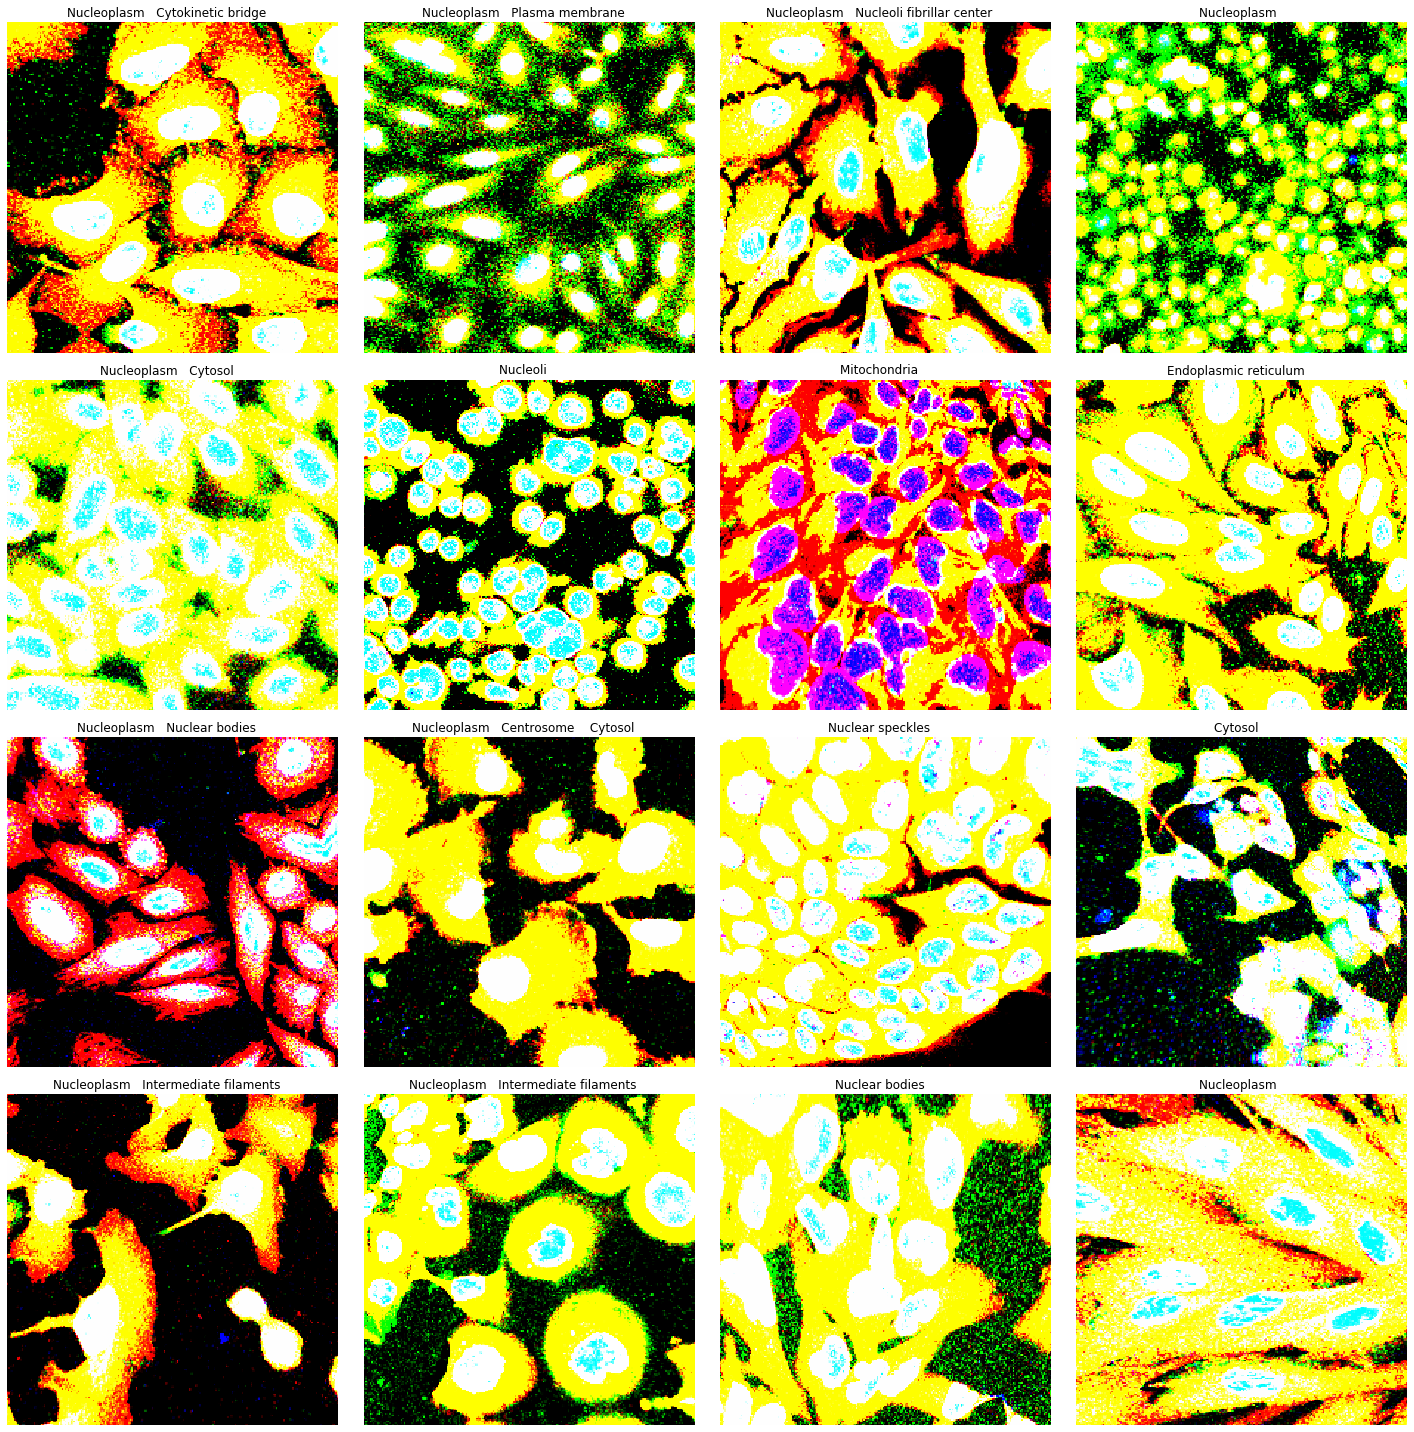

In [13]:
data.show_batch(rows = 4)

In [14]:
resnet50 = ResNet(encoder_depth = 50, num_in_channels=4)

f1_score = partial(fbeta, thresh = 0.35, beta = 1)
acc = partial(accuracy_thresh, thresh = 0.35)

In [15]:
# Function taken from https://github.com/fastai/fastai/blob/master/fastai/vision/learner.py
def _resnet_split(m:nn.Module): return (m[0][6],m[1])

In [16]:
learn = cnn_learner(data, base_arch = resnet50, cut = -2, split_on = _resnet_split, 
                    lin_ftrs=[512, 128, 28], ps=0.4,
                    metrics = [f1_score, acc], loss_func = FocalLoss()).to_fp16()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


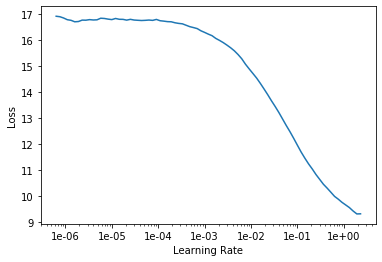

In [16]:
learn.lr_find()
learn.recorder.plot()

In [17]:
learn.fit_one_cycle(2, 1e-2)

epoch,train_loss,valid_loss,fbeta,accuracy_thresh,time
0,1.494759,10.738559,0.341066,0.917813,03:53
1,1.339342,1.370260,0.349078,0.917989,03:53


In [18]:
learn.fit_one_cycle(2, slice(5e-4, 5e-3))

epoch,train_loss,valid_loss,fbeta,accuracy_thresh,time
0,1.318331,1.302766,0.371317,0.920621,03:51
1,1.298176,1.270348,0.369028,0.914789,03:53


In [19]:
save_model(learn, 'F', 'smol', 1)

In [20]:
learn.unfreeze()

In [21]:
learn.fit_one_cycle(5, slice(5e-4, 5e-3))

epoch,train_loss,valid_loss,fbeta,accuracy_thresh,time
0,1.304886,1.310358,0.355242,0.915894,03:53
1,1.291035,1.362303,0.355058,0.915618,03:53
2,1.264759,1.261544,0.373045,0.919401,03:56
3,1.253539,1.220457,0.388101,0.924259,03:53
4,1.257353,1.218145,0.391220,0.923307,03:55


In [22]:
save_model(learn, 'UF', 'smol', 1)

In [23]:
learn.fit_one_cycle(3, slice(5e-5, 5e-4))

epoch,train_loss,valid_loss,fbeta,accuracy_thresh,time
0,1.250590,1.208806,0.400972,0.927121,03:51
1,1.245807,1.248242,0.380059,0.923430,03:51
2,1.244102,1.192906,0.405322,0.926315,03:53


In [24]:
save_model(learn, 'UF', 'smol', 2)

## GO BIG

In [25]:
#Mean and Standard Deviation As per competition kernals
protein_stats = ([0.08069, 0.05258, 0.05487, 0.08282], [0.13704, 0.10145, 0.15313, 0.13814]) 

data = (src.transform(get_transforms(do_flip = True, flip_vert = True, max_zoom = 1.2, max_rotate = 30,
                                     max_warp = 0.3, max_lighting = 0.05), size = 512)
            .databunch(bs = 16)
            .normalize(protein_stats))

In [26]:
learn = cnn_learner(data, base_arch = resnet50, cut = -2, split_on = _resnet_split, 
                    lin_ftrs=[512, 128, 28], ps=0.4,
                    metrics = [f1_score, acc], loss_func = FocalLoss()).to_fp16()

In [27]:
load_model(learn,'UF', 'smol', 2)

In [28]:
learn.fit_one_cycle(3, slice(5e-4, 5e-3))

epoch,train_loss,valid_loss,fbeta,accuracy_thresh,time
0,1.263308,1.234356,0.389815,0.922439,06:59
1,1.233950,1.226366,0.402729,0.927221,06:51
2,1.225425,1.213594,0.400404,0.929730,06:51


In [29]:
save_model(learn, 'F', 'big', 1)

In [30]:
learn.freeze_to(-7)

In [31]:
learn.fit_one_cycle(3, slice(1e-4, 1e-3))

epoch,train_loss,valid_loss,fbeta,accuracy_thresh,time
0,1.233247,1.273912,0.382727,0.926622,07:14
1,1.220768,1.182785,0.405402,0.927113,07:12
2,1.204267,1.186200,0.397711,0.925494,07:14


In [32]:
learn.unfreeze()

In [33]:
save_model(learn, 'UF', 'big', 1)

In [34]:
learn.fit_one_cycle(5, slice(1e-4, 1e-3), wd=1e-3)

epoch,train_loss,valid_loss,fbeta,accuracy_thresh,time
0,1.196814,1.162641,0.422980,0.931065,07:14
1,1.195379,1.218141,0.389475,0.924228,07:12
2,1.173490,1.207191,0.422241,0.930513,07:11
3,1.185796,1.157595,0.417650,0.930644,07:15
4,1.196115,1.187831,0.414478,0.929408,07:12


In [35]:
save_model(learn, 'UF', 'big', 2)

In [36]:
learn.fit_one_cycle(8, slice(1e-5, 1e-4), wd=1e-3)

epoch,train_loss,valid_loss,fbeta,accuracy_thresh,time
0,1.207256,1.141003,0.430289,0.930828,07:12
1,1.196511,1.130940,0.430520,0.931863,07:13
2,1.188126,1.148299,0.423897,0.928256,07:14
3,1.201654,1.152123,0.421920,0.928916,07:14
4,1.170129,1.143182,0.433571,0.932232,07:14
5,1.182679,1.311838,0.411775,0.927274,07:14
6,1.174637,1.157077,0.414266,0.926822,07:14
7,1.175077,1.129384,0.436680,0.929462,07:13


In [37]:
save_model(learn, 'UF', 'big', 3)

In [38]:
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [39]:
preds[0]

tensor([-0.3213, -1.4521, -0.4929, -0.6060, -0.6230, -0.5908, -3.3262, -1.4492,
        -3.5078, -4.1055, -4.8594, -1.9443, -2.7305, -2.4824, -3.1230, -4.0781,
        -1.9785, -3.5996, -2.0020, -1.3184, -2.4180, -1.9512, -1.9111, -2.0664,
        -1.8311, -1.8760, -2.1504, -3.6426])

In [41]:
predictions = torch.sigmoid(preds)
predictions[0]

tensor([0.4204, 0.1897, 0.3792, 0.3530, 0.3491, 0.3564, 0.0347, 0.1901, 0.0291,
        0.0162, 0.0077, 0.1252, 0.0612, 0.0771, 0.0422, 0.0167, 0.1215, 0.0266,
        0.1190, 0.2111, 0.0818, 0.1244, 0.1289, 0.1124, 0.1381, 0.1329, 0.1043,
        0.0255])

In [42]:
test_df = pd.read_csv(path/'sample_submission.csv')
test_df.head()

,Id,Predicted
0,00008af0-bad0-11e8-b2b8-ac1f6b6435d0,0
1,0000a892-bacf-11e8-b2b8-ac1f6b6435d0,0
2,0006faa6-bac7-11e8-b2b7-ac1f6b6435d0,0
3,0008baca-bad7-11e8-b2b9-ac1f6b6435d0,0
4,000cce7e-bad4-11e8-b2b8-ac1f6b6435d0,0


In [50]:
# pred_labels = [' '.join(list([str(i) for i in np.nonzero(row>0.25)[0]])) for row in np.array(predictions)]
# tdf = pd.DataFrame({'Id':test_df.Id,'Predicted':pred_labels})
# tdf.head(20)
tdf.to_csv('submission.csv', header=True, index=False)

In [51]:
! kaggle competitions submit -c human-protein-atlas-image-classification -f submission.csv -m "2nd Sub"

100%|████████████████████████████████████████| 620k/620k [00:11<00:00, 57.2kB/s]
Successfully submitted to Human Protein Atlas Image Classification